In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # To make some plots
import matplotlib.pyplot as plt # To make some plots

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


### The digits have been size-normalized and centered in a fixed-size image.
>  Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

In [2]:
mnist_df = pd.read_csv("../input/digit-recognizer/train.csv")
mnist_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
mnist_df.shape[0]

42000

In [4]:
###  Each row represents one image containing a character

In [5]:
#Is there a Null Value?
mnist_df.isnull().sum().max()

0

In [6]:
# Hence no null value is there!
#Now lets see how many samples we have in each class and what different classes do we have?
label_list = mnist_df["label"].unique()
label_list.sort()
print('labels are :',label_list)

labels are : [0 1 2 3 4 5 6 7 8 9]


<AxesSubplot:xlabel='label', ylabel='count'>

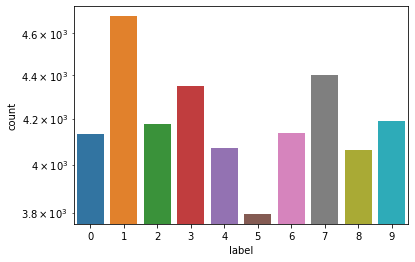

In [7]:
sns.countplot(x ='label', data = mnist_df, log = True) # plot on the log scale

# This could be Problem no one!!!!!   - Class Imbalance Problem!

In [8]:
from fastai.vision.all import *
from tqdm import tqdm
import pickle, gzip, math, torch, matplotlib as mpl
import torch.nn.functional as F
import pathlib
from pathlib import Path

#Mixed-precision training
from fastai.callback.fp16 import *

In [9]:
# now Lets split our data into training and testing set!

valid_df = mnist_df[35000:42000]
training_df = mnist_df[0:35000]

In [10]:
training_df.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
34995,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34996,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34998,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
x_train = torch.tensor(training_df.drop(['label'], axis = 1).values).float() / 255.0
y_train = torch.tensor(training_df.label.values).float().unsqueeze(1)
x_valid = torch.tensor(valid_df.drop(['label'], axis = 1).values).float() / 255.0
y_valid = torch.tensor(valid_df.label.values).float().unsqueeze(1)

print(x_train.shape, y_train.shape)

torch.Size([35000, 784]) torch.Size([35000, 1])


In [12]:
# Reshape image in 3 dimensions (height = 28px, width = 28px) for visualization purposes
x_train_image = torch.reshape(x_train, (-1,28,28))
print(x_train_image.shape)

torch.Size([35000, 28, 28])


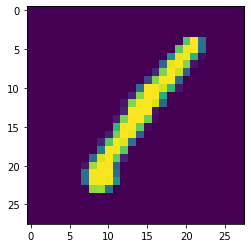

In [13]:
plt.imshow(x_train_image[0])

## Deep Learning Approach!

## First model with Pytorch
#### Step 0: Preparation : PyTorch is required to return a tuple of (X,Y) when indexed. we need this to use PyTorch

In [14]:
dset = list(zip(x_train,y_train.squeeze(1).long()))
valid_dset = list(zip(x_valid,y_valid.squeeze(1).long()))
x,y = dset[0]   #In tuple form
x.shape,y

(torch.Size([784]), tensor(1))

In [15]:
#Neighter we take one by one sample to train neither we take all take at once,
#So instead we take a compromise between the two: 
#we calculate the average loss for a few data items at a time. 
#This is called a mini-batch.
#The number of data items in the mini-batch is called the batch size. 
#A larger batch size means that you will get a more accurate and stable 
#estimate of your dataset's gradients from the loss function, 
#but it will take longer, and you will process fewer mini-batches per epoch. 

#Choosing a good batch size is one of the decisions you need to make as a 
#deep learning practitioner to train your model quickly and accurately.

In [16]:
# That is why we also need a Dataloader. 
#A DataLoader can take any Python collection and turn it into an iterator 
#over many batches

In [17]:
# When we pass a Dataset to a DataLoader we will get back many 
#batches which are themselves tuples of tensors representing batches of 
#independent and dependent variables

In [18]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256]))

#### Step 1: Initialization

In [19]:
# We need an (initially random) weight for every pixel (this is the initialize step in our seven-step process).
# The function weights times pixels won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its intercept is 0). Thus, we need a bias b. In neural networks, the w in the equation y=w*x+b is called the weights, and the b is called the bias. Together, the weights and bias make up the parameters.
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [20]:
# The shape of our weights should be 784x10, because at the end of our model, we want to get 10 predictions, one for each number between 0 and 9. We can then take the argmax of each value. The largest value obtained will be our prediction.

In [21]:
weights = init_params((28*28,10))
bias = init_params(10)
weights[0], bias[0]

(tensor([-0.8428, -0.7926,  1.0255,  0.2581, -1.4997,  0.9822, -1.5766,  0.3379,
          0.6072,  0.2734], grad_fn=<SelectBackward>),
 tensor(1.1218, grad_fn=<SelectBackward>))

#### Step 2: Prediction

In [22]:
# def linear1(xb): 
#     return xb@weights + bias

# preds = linear1(x_train)
# preds[0]


In [23]:
#Bonus ! Adding a Nonlinearity
#So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

In [24]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))  #RELU 
    res = res@w2 + b2
    return res

w1 = init_params((28*28,50))
b1 = init_params(50)
w2 = init_params((50,10))
b2 = init_params(10)

preds = simple_net(x_train)
preds[0], preds.shape

(tensor([ 1.1774e+01, -4.3849e-02, -7.1576e+01, -1.5422e+01,  2.4311e+01,
         -2.6154e+01, -4.5896e+01,  2.4718e+01, -1.9252e+01,  3.7994e+01],
        grad_fn=<SelectBackward>),
 torch.Size([35000, 10]))

In [25]:
#That little function res.max(tensor(0.0)) is called a rectified linear unit, also known as ReLU. We think we can all agree that rectified linear unit sounds pretty fancy and complicated... But actually, there's nothing more to it than res.max(tensor(0.0))—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as F.relu

In [26]:
#### Step 3: Compute Loss - Cross Entropy
#A lot of loss functions exists, each of them is helpful in some specific situations. Four our problem, a good loss function is cross-entropy.

#For more info about cross entropy, check https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
#For even more info about the maths behind cross-entropy, check III.7) of https://www.kaggle.com/toldo171/digit-recognition-from-scratch

In [27]:
#First, we will need to compute the softmax of our activations
#Then, if we consider a classification problem where the model has to determine if an image is a 1, 2, 3 or 4, and the softmax probabilities (S) and labels (T) of the model are:

In [28]:
#Softmax is continuously differentiable function. This makes it possible to calculate the derivative of the loss function with respect to every weight in the neural network. This property allows the model to adjust the weights accordingly to minimize the loss function (model output close to the true values).

#In PyTorch, F.log_softmax and F.nll_loss are combined in one optimized function, F.cross_entropy.

In [29]:
loss_func = F.cross_entropy

In [30]:
# Step 4: Compute Gradient
###This step is pretty straightforward: we compute our predictions and then the loss between our predictions and the real values, using softmax activations and cross entropy loss (regrouped in F.cross_entropy).

In [31]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()

In [32]:
# Step 5: Update weights
###Our only remaining step is to update the weights and biases based on the gradient and learning rate (i.e. param = param - param_grad * lr). When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the data attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [33]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [34]:
# Step 6, 7: Combining everything
# We also want to check how we're doing, by looking at the accuracy of the validation set, so let's define an accuracy metric. We take the argmax of our output, to find out which of the numbers of the softmax is the highest. The index of that is our prediction. Then we check if it's equal with the real value, and we take the mean of it

In [35]:
def accuracy(out, yb): 
   
    return (torch.argmax(out, dim=1)==yb).float().mean()

def validate_epoch(model):
    accs = [accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [36]:
#Let's try to run this for one batch (256 images) to see if everything works:

preds = simple_net(xb)
print(preds[0], preds.shape)
print(loss_func(preds, yb))
print(accuracy(preds, yb))

tensor([ 1.1774e+01, -4.3849e-02, -7.1576e+01, -1.5422e+01,  2.4311e+01,
        -2.6154e+01, -4.5896e+01,  2.4718e+01, -1.9252e+01,  3.7994e+01],
       grad_fn=<SelectBackward>) torch.Size([256, 10])
tensor(61.2915, grad_fn=<NllLossBackward>)
tensor(0.0781)


In [37]:
# That's our starting point. We have around 10% accuracy, which is totally normal since our initialisation step was done randomly. Let's train for one epoch, and see if the accuracy improves:

In [38]:
lr = 1
params = w1, b1, w2, b2
train_epoch(simple_net, lr, params)
validate_epoch(simple_net)

0.676

In [39]:
#It works! Let's try for a few more epochs:

In [40]:
for i in range(50):
    train_epoch(simple_net, lr, params)
    print(validate_epoch(simple_net), end=' ')

0.7497 0.7934 0.8416 0.8612 0.8705 0.8793 0.8856 0.8913 0.8948 0.8996 0.9022 0.9056 0.9076 0.9107 0.9133 0.9143 0.9151 0.9158 0.9169 0.9185 0.9193 0.9204 0.9201 0.92 0.9211 0.9232 0.9232 0.9239 0.9243 0.9254 0.9251 0.9253 0.9257 0.9261 0.9267 0.9272 0.9283 0.9283 0.9286 0.9296 0.9296 0.931 0.9317 0.9315 0.9318 0.9317 0.9321 0.9318 0.9324 0.9325 

In [41]:
#And this is it! The rest is only "tricks" to improve the results, but here we just finished our first deep learning model from scratch!

In [42]:
sample = pd.read_csv("../input/digit-recognizer/train.csv")
sample.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
test = pd.read_csv("../input/digit-recognizer/test.csv")


In [44]:
x_test = torch.tensor(test.values).float() / 255.0

In [45]:
ans = simple_net(x_test)

In [46]:
ans

tensor([[ -3.3293,   3.3135,  27.1425,  ...,  11.4439,  -9.0879, -25.0229],
        [ 41.9408, -21.7943,   9.9450,  ...,  21.5605,  -5.5706,  16.0578],
        [  0.1405,  -2.1418,  -0.8448,  ...,   2.2305,   2.0500,   6.7653],
        ...,
        [-11.2130,   2.4687,  -2.0384,  ...,  -6.1488,   5.8679,   9.5411],
        [  0.6026,  -3.0000,  -2.1210,  ...,   6.8950,  -5.8208,  14.0424],
        [ -6.7358,   1.8481,  22.3734,  ...,   9.6887,  -8.5867, -25.0702]],
       grad_fn=<AddBackward0>)

In [47]:
ans1 = torch.argmax(ans, dim=1)

In [48]:
ans1

tensor([2, 0, 9,  ..., 3, 9, 2])

In [49]:
preds = ans1

In [50]:
df_result = pd.DataFrame(
    {
        "Label": preds.tolist()
    }
)
df_result.index += 1
df_result.head()

,Label
1,2
2,0
3,9
4,4
5,2


In [51]:
df_result.to_csv("submission.csv", index_label="ImageId")

In [52]:
df_result

,Label
1,2
2,0
3,9
4,4
5,2
...,...
27996,9
27997,7
27998,3
27999,9
